#### Double DQN with proioritized memory in Tensorflow 2.0

In [27]:
import gym
import time
import tensorflow as tf
import numpy as np
import logging

from collections import deque, OrderedDict
from ipypb import track
from copy import copy

In [28]:
import matplotlib.pyplot as plt
import matplotlib

from IPython import display

%matplotlib inline

In [29]:
try:
    try:
        gpu = tf.config.experimental.list_physical_devices('GPU')[0]
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as error:
        print('This config has already been invoked. Error message:')
        print(error)
except Exception:
    pass

In [30]:
env = gym.make('MsPacman-v0')
actions_n = env.action_space.n

In [31]:
class QNet(tf.keras.Model):
    
    def __init__(self, actions_n):
        super(QNet, self).__init__()
        kinit = tf.keras.initializers.VarianceScaling()
        self.conv1 = tf.keras.layers.Conv2D(32, (8, 8), 4, 'same', kernel_initializer=kinit)
        self.conv2 = tf.keras.layers.Conv2D(64, (4, 4), 2, 'same', kernel_initializer=kinit)
        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), 1, 'same', kernel_initializer=kinit)
        self.flat = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(256, kernel_initializer=kinit)
        self.dense2 = tf.keras.layers.Dense(actions_n, kernel_initializer=kinit)
        
    def call(self, observation):
        x = self.conv1(observation)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flat(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

optimizer = tf.keras.optimizers.Adam(lr=0.0025)
mse = tf.keras.losses.MeanSquaredError()

In [32]:
### Implement probability here
class Memory:

    def __init__(self, _max=10, batch_size=2, epsilon=1e-4, alpha=0.7):
        self._max = _max
        self.td_errors = [0 for _ in range(_max)]
        self.memories = [0 for _ in range(_max)]
        self.batch_size = batch_size
        self.epislon = epsilon
        self.alpha = alpha

    def add_memory(self, td_error, memory):
        if self.td_errors[0] < td_error:
            self.td_errors[0] = td_error
            self.memories[0] = memory
            self.__sort()

    def update_memories(self, td_errors):
        self.td_errors[-self.batch_size:] = td_errors
        self.__sort()

    def get_memories(self):
        perm = np.random.permutation(self._max)[:self.batch_size]
        mem = np.array(self.memories)[perm]
        obs = np.concatenate(mem[:,0])
        obs_n = np.concatenate(mem[:,2])
        return obs, mem[:,1], obs_n, mem[:,3], mem[:,4]
    
    def refresh(self):
        self.td_errors = [0 for _ in range(self._max)]
        self.memories = [0 for _ in range(self._max)]

    def __sort(self):
        zipped = sorted(zip(self.td_errors, self.memories), key=lambda x:x[0])
        self.memories = [x for _, x in zipped]
        self.td_errors = sorted(self.td_errors)

In [33]:
color = np.array([210, 164, 74]).mean()

def preprocess(image):
    image = image[1:172:2,::2]
    image = image.mean(axis=-1)
    image[image==color] = 0
    image = (image-128)/(128) 
    image = image[np.newaxis,:,:,np.newaxis]
    return image

def epsilon_greedy(action, step):
    epsilon = max(EPS_MIN, EPS_MAX - (EPS_MAX-EPS_MIN) * step/EPS_STEPS)
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(actions_n)
    else:
        return action
    
def pick_best_q(next_qs, best_next_a):
    if isinstance(best_next_a, int):
        return next_qs[:,best_next_a]
    else:
        best_next_a = best_next_a.astype('int32')
        best_next_a_en = np.zeros((len(best_next_a), actions_n))
        best_next_a_en[np.arange(len(best_next_a)), best_next_a] = 1
        return (next_qs * best_next_a_en).sum(axis=-1)

def sample_memories():
    perm = np.random.permutation(len(exp_buffer))[:BATCH_SIZE]
    mem = np.array(exp_buffer)[perm]
    obs = np.concatenate(mem[:,0])
    obs_n = np.concatenate(mem[:,2])
    return obs, mem[:,1], obs_n, mem[:,3], mem[:,4]

def play_pacman(render_jupyter=True):
    done = False
    observation = env.reset()
    if render_jupyter:
        img = plt.imshow(env.render(mode='rgb_array'))
    while not done:
        if render_jupyter:
            img.set_data(env.render(mode='rgb_array'))
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            env.render()
            time.sleep(0.020)
        observation = preprocess(observation)
        action = main_q(observation).numpy().argmax(axis=-1)
        action = epsilon_greedy(action, np.inf)
        observation, _, done, _ = env.step(action)
    env.close()

In [34]:
@tf.function
def train_network(obs, rewards, actions):
    actions = tf.dtypes.cast(tf.one_hot(actions, actions_n), dtype='float64') #esto te da matriz len(actions_n)*deptphth     with tf.GradientTape() as tape:
    all_qs = main_q(obs)
    q_act = tf.squeeze(tf.reduce_sum(all_qs*actions, axis=-1, keepdims=True), axis=-1)
    loss = mse(rewards, q_act)
    gradients = tape.gradient(loss, main_q.trainable_variables)
    optimizer.apply_gradients(zip(gradients, main_q.trainable_variables))

In [35]:
EPISODES = 800
GAMMA = 0.97
START_STEP = 1000
COPY_STEP = 100
TRAIN_STEP = 4

MEM_LEN = 20000
BATCH_SIZE = 48

EPS_MIN = 0.05
EPS_MAX = 1
EPS_STEPS = 500000

global_step = 0

exp_buffer = deque(maxlen=MEM_LEN)

main_q = QNet(actions_n)
target_q = QNet(actions_n)

In [36]:
for _ in track(range(EPISODES)):

    done = False
    observation = env.reset()
    episodic_reward = 0
    
    while not done:

        observation = preprocess(observation)
        best_action = main_q(observation).numpy().argmax(axis=-1)
        action = epsilon_greedy(best_action, global_step)

        observation_n, reward, done, _ = env.step(action)
        exp_buffer.append([observation, action, preprocess(observation_n), reward, done])

        if (global_step % TRAIN_STEP) == 0 and (global_step > START_STEP):

            t_observation, t_action, t_observation_n, t_reward, t_done = sample_memories()
            
            best_next_a = main_q(t_observation_n).numpy().argmax(axis=-1)
            next_qs = target_q(t_observation_n).numpy()
            best_next_q = pick_best_q(next_qs, best_next_a)
            
            rewards = np.expand_dims(t_reward + GAMMA*best_next_q*(1-t_done), axis=-1).astype('float32')
            
            train_network(t_observation, rewards, t_action.astype('int32'))
            
        if ((global_step+1) % COPY_STEP) == 0 and (global_step > START_STEP):
            target_q = copy(main_q)
        
        observation = observation_n
        episodic_reward += reward
        global_step += 1
    
    print('Episodic reward: '+str(episodic_reward)+'. On global step: '+str(global_step)+'. Epsilon: '+str(max(EPS_MIN, EPS_MAX - (EPS_MAX-EPS_MIN) * global_step/EPS_STEPS)))

AttributeError: 'super' object has no attribute '__iter__'

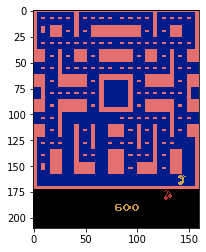

In [37]:
play_pacman()